<a href="https://colab.research.google.com/github/keran-w/3d-deep-learning/blob/main/Notebooks/Multi_View_Bitmap_Classification_Using_Octree_Based_Representations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install lightning

In [128]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

from tqdm import tqdm
from google.colab import drive
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from pandas_profiling import ProfileReport
from matplotlib.animation import FuncAnimation

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import lightning.pytorch as pl

# Setup

In [1]:
drive.mount('/content/drive', force_remount=True)
clear_output()

In [2]:
dataset_name = 'modelnet40'
%cd /content/drive/MyDrive/dataset/{dataset_name}
base_path = Path('.')

/content/drive/MyDrive/dataset/modelnet40


# Data and Visualization

In [131]:
metadata = pd.read_csv(base_path/'metadata_modelnet40.csv')
ProfileReport(metadata, minimal=True, dark_mode=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
all_labels = [label for label in os.listdir(base_path/'ModelNet40-path') 
                    if os.path.isfile(base_path/f'ModelNet40-path/{label}/train/{label}_0001.path')]
num_labels = len(all_labels)

In [25]:
dataset_dir = base_path/'ModelNet40-path'

In [28]:
def load_path(file_path):
    path_graph = open(file_path, 'r').read().split('\n')[1:]
    num_vert, num_edge = [int(i) for i in path_graph[0].split()]
    verts = [[float(v_s) for v_s in v_str.split()] for v_str in path_graph[1:num_vert+1]]
    edges = [[int(e_s) for e_s in e_str.split()] for e_str in path_graph[num_vert+1:]][:-1]
    verts = np.array(verts)
    return verts, edges
  
file_path = metadata.object_path[0].replace('.off', '.path')
verts, edges = load_path(dataset_dir/file_path )

100%|██████████| 11678/11678 [00:18<00:00, 615.69it/s]


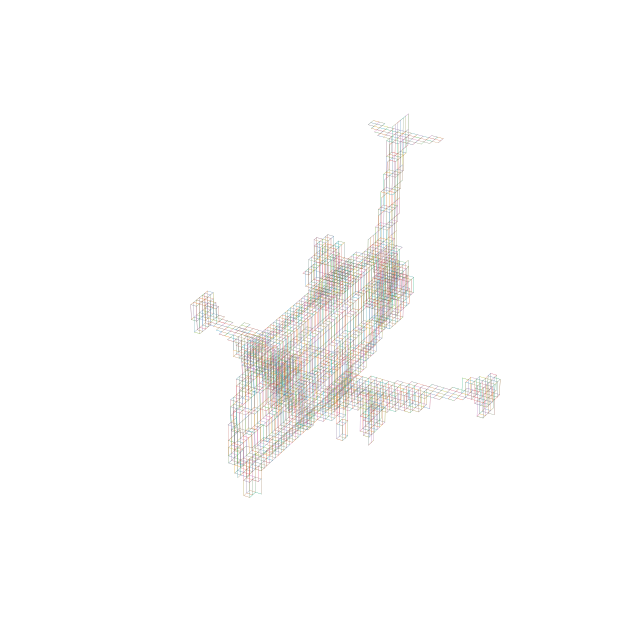

In [127]:
def visualize(verts, edges):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    for edge in tqdm(edges):
        ax.plot(
            [verts[edge[0], 0], verts[edge[1], 0]],
            [verts[edge[0], 1], verts[edge[1], 1]],
            [verts[edge[0], 2], verts[edge[1], 2]],
            linewidth=0.1,
        )
    ax.axis('off')
    plt.show()

visualize(verts, edges)

In [38]:
def get_bitmap(verts, axis, round=2):
    verts_ = (np.round(verts, 2) * 100).astype('int')
    bitmap = np.zeros((100,100))
    for i,j in verts_[:,axis]:
        bitmap[i,j] += 1
    return bitmap / np.max(bitmap)

bitmap_0 = get_bitmap(verts, [0,1])
bitmap_1 = get_bitmap(verts, [1,2])
bitmap_2 = get_bitmap(verts, [2,0])

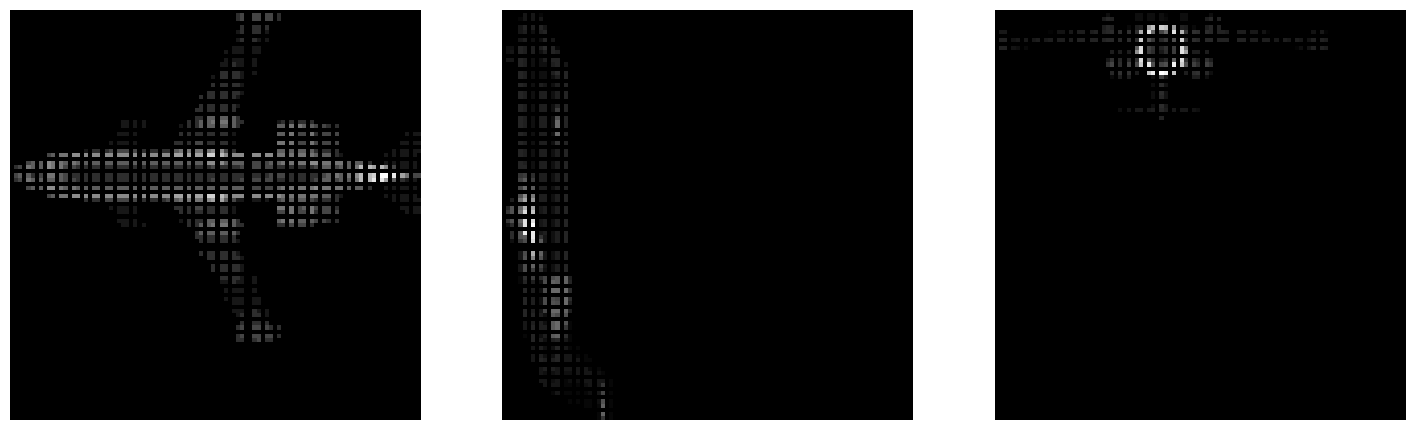

In [40]:
def visualize_bitmap(ax, bitmap):
    ax.imshow(bitmap, cmap='gray')
    ax.axis('off')

fig, ax = plt.subplots(1,3, figsize=(18,6))
visualize_bitmap(ax[0], bitmap_0)
visualize_bitmap(ax[1], bitmap_1)
visualize_bitmap(ax[2], bitmap_2)
plt.show()

# Dataset

In [114]:
def get_bitmap(verts, axis, precision=8):
    verts_ = (np.round(verts*2**precision)).astype('int')
    bitmap = np.zeros((2**precision,2**precision))
    for i,j in verts_[:,axis]:
        bitmap[i,j] += 1
    return bitmap / np.max(bitmap)

def get_bitmaps(verts, edges):
    bm1 = get_bitmap(verts, [0,1])
    bm2 = get_bitmap(verts, [1,2])
    bm3 = get_bitmap(verts, [2,0])
    return [bm1, bm2, bm3]

class bitmapDataset(Dataset):
    def __init__(self, metadata, all_labels, dataset_dir, mode, test_size=0.15):
        assert mode in ('train', 'valid', 'test')
        self.labels = all_labels
        le = LabelEncoder().fit(all_labels)
        self.label_map = dict((zip(le.classes_, le.transform(le.classes_))))

        metadata_ = metadata.query('`class` in @all_labels')
        train_data = metadata_.query('split == "train"')
        test_data = metadata_.query('split == "test"')
        train_data, valid_data = train_test_split(train_data, stratify=train_data['class'], test_size=test_size)
        self.train_paths, self.train_labels = train_data.object_path.tolist(), train_data['class'].tolist()
        self.valid_paths, self.valid_labels = valid_data.object_path.tolist(), valid_data['class'].tolist()
        self.test_paths, self.test_labels = test_data.object_path.tolist(), test_data['class'].tolist()
        self.mode = mode
        self.dataset_dir = dataset_dir

    def __len__(self):
        return eval(f'len(self.{self.mode}_paths)')
    
    def __getitem__(self, index):
        path = eval(f'self.{self.mode}_paths')[index].replace('off', 'path')
        label = eval(f'self.{self.mode}_labels')[index]
        bitmaps = get_bitmaps(*load_path(self.dataset_dir/path))

        item = {
            'mode': self.mode,
            'X': torch.tensor(bitmaps).float(),
            'y': self.label_map[label]
        }

        return item

def get_loader(metadata, all_labels, dataset_dir, mode, batch_size=128, shuffle=False):
    return DataLoader(bitmapDataset(metadata, all_labels, dataset_dir, mode), batch_size=batch_size, shuffle=shuffle)

# train_dataset = bitmapDataset(metadata, all_labels, dataset_dir, 'train')
# valid_dataset = bitmapDataset(metadata, all_labels, dataset_dir, 'valid')
# test_dataset = bitmapDataset(metadata, all_labels, dataset_dir, 'test')
train_loader = get_loader(metadata, all_labels, dataset_dir, 'train', shuffle=True)
valid_loader = get_loader(metadata, all_labels, dataset_dir, 'valid', shuffle=False)
test_loader = get_loader(metadata, all_labels, dataset_dir, 'test', shuffle=False)

In [119]:
sample_batch = next(iter(train_loader))
sample_batch['X'].shape, sample_batch['y'].shape

(torch.Size([128, 3, 256, 256]), torch.Size([128]))

# Model

# Trainer

In [126]:
class CNNClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()

    def training_step(self, batch, batch_idx):
        ...

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

model = CNNClassifier()

trainer = pl.Trainer()
trainer.fit(model, train_loader, valid_loader)